<a href="https://colab.research.google.com/github/AiJared/job_matching_model/blob/main/job_matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.18.0


In [2]:
# Mock data creation (you'll replace this with your actual data loading)
# This creates dummy data for development purposes
# In a real scenario, you'd load your candidates.csv, jobs.csv, and matches.csv

def create_mock_data():
    # Create candidate data
    candidates = pd.DataFrame({
        'id': range(1, 101),
        'skills': [
            'python java sql', 'javascript html css', 'c++ python', 'java spring hibernate',
            'react node.js mongodb', 'python django flask', 'java spring boot',
            'javascript react redux', 'python numpy pandas', 'c# .net sql'
        ] * 10,
        'experience': np.random.randint(0, 11, 100),
        'education': np.random.choice(['High School', 'Bachelor', 'Master', 'PhD'], 100),
        'location': np.random.choice(['New York', 'San Francisco', 'Seattle', 'Austin', 'Chicago'], 100)
    })

    # Create job data
    jobs = pd.DataFrame({
        'id': range(1, 51),
        'title': [
            'Software Engineer', 'Web Developer', 'Data Scientist', 'Backend Developer',
            'Frontend Developer', 'Full Stack Developer', 'DevOps Engineer',
            'ML Engineer', 'Data Analyst', 'Software Developer'
        ] * 5,
        'required_skills': [
            'python java sql', 'javascript html css', 'python pandas scikit-learn', 'java spring hibernate',
            'react javascript css', 'python django javascript', 'aws docker kubernetes',
            'python tensorflow keras', 'sql python tableau', 'c# .net sql'
        ] * 5,
        'min_experience': np.random.randint(0, 6, 50),
        'required_education': np.random.choice(['High School', 'Bachelor', 'Master', 'PhD'], 50),
        'location': np.random.choice(['New York', 'San Francisco', 'Seattle', 'Austin', 'Chicago'], 50)
    })

    # Create match data (some good matches, some poor matches)
    matches = []
    for _ in range(300):
        candidate_id = np.random.randint(1, 101)
        job_id = np.random.randint(1, 51)

        # Simplistic match score calculation for demo
        candidate = candidates[candidates['id'] == candidate_id].iloc[0]
        job = jobs[jobs['id'] == job_id].iloc[0]

        # Basic matching logic - more sophisticated in real implementation
        skill_match = len(set(candidate['skills'].split()) & set(job['required_skills'].split())) / len(set(job['required_skills'].split()))
        exp_match = 1 if candidate['experience'] >= job['min_experience'] else 0.5
        edu_match = 1 if candidate['education'] == job['required_education'] else 0.7
        loc_match = 1 if candidate['location'] == job['location'] else 0.8

        match_score = (skill_match * 0.5 + exp_match * 0.3 + edu_match * 0.1 + loc_match * 0.1)

        matches.append({
            'candidate_id': candidate_id,
            'job_id': job_id,
            'match_score': match_score
        })

    matches_df = pd.DataFrame(matches)

    return candidates, jobs, matches_df

# Generate mock data
candidates_df, jobs_df, matches_df = create_mock_data()

# Display the first few rows of each dataframe
print("Candidates DataFrame:")
print(candidates_df.head())
print("\nJobs DataFrame:")
print(jobs_df.head())
print("\nMatches DataFrame:")
print(matches_df.head())

Candidates DataFrame:
   id                 skills  experience    education       location
0   1        python java sql           8     Bachelor  San Francisco
1   2    javascript html css           2          PhD        Chicago
2   3             c++ python           8          PhD  San Francisco
3   4  java spring hibernate           9  High School        Chicago
4   5  react node.js mongodb           6  High School  San Francisco

Jobs DataFrame:
   id               title             required_skills  min_experience  \
0   1   Software Engineer             python java sql               3   
1   2       Web Developer         javascript html css               4   
2   3      Data Scientist  python pandas scikit-learn               5   
3   4   Backend Developer       java spring hibernate               5   
4   5  Frontend Developer        react javascript css               4   

  required_education       location  
0                PhD        Chicago  
1                PhD  San Franci

In [3]:
# Load actual data (uncomment and modify for your actual data)
"""
# Load your actual data
candidates_df = pd.read_csv('candidates.csv')
jobs_df = pd.read_csv('jobs.csv')
matches_df = pd.read_csv('matches.csv')

# Display basic statistics
print("Candidates DataFrame Info:")
print(candidates_df.info())
print("\nJobs DataFrame Info:")
print(jobs_df.info())
print("\nMatches DataFrame Info:")
print(matches_df.info())
"""

'\n# Load your actual data\ncandidates_df = pd.read_csv(\'candidates.csv\')\njobs_df = pd.read_csv(\'jobs.csv\')\nmatches_df = pd.read_csv(\'matches.csv\')\n\n# Display basic statistics\nprint("Candidates DataFrame Info:")\nprint(candidates_df.info())\nprint("\nJobs DataFrame Info:")\nprint(jobs_df.info())\nprint("\nMatches DataFrame Info:")\nprint(matches_df.info())\n'

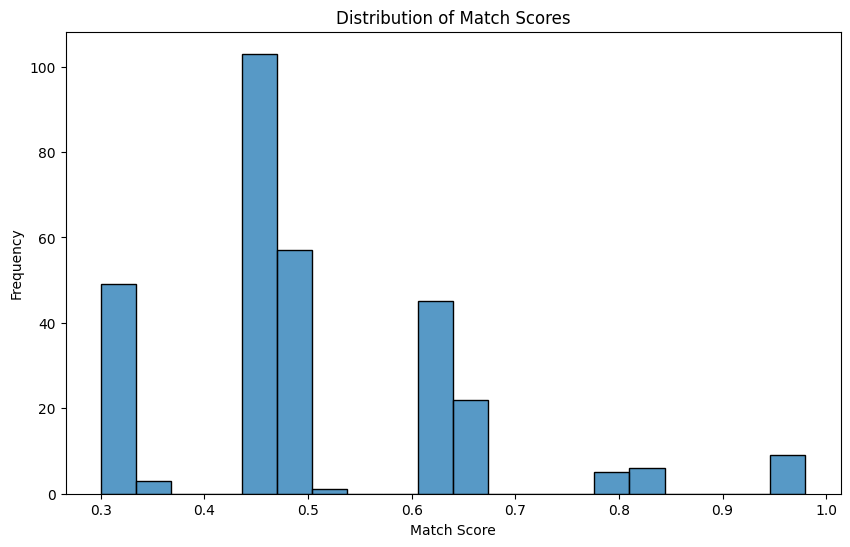

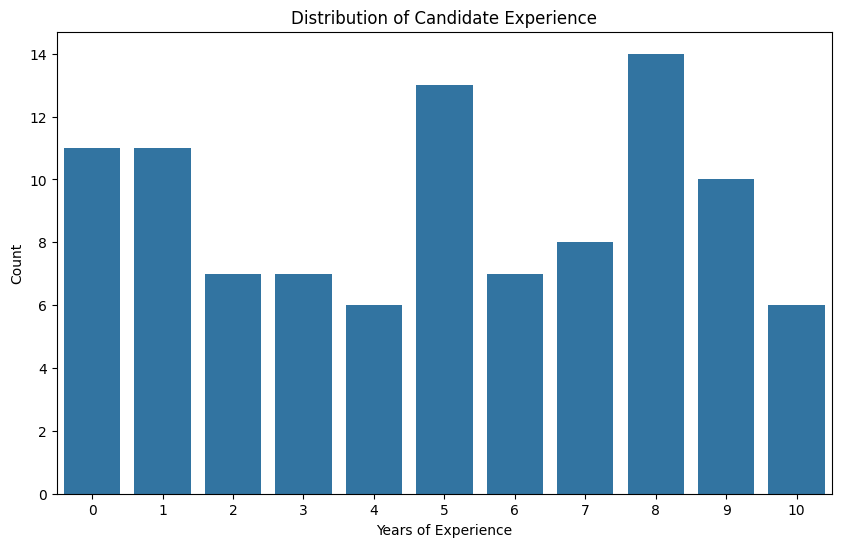

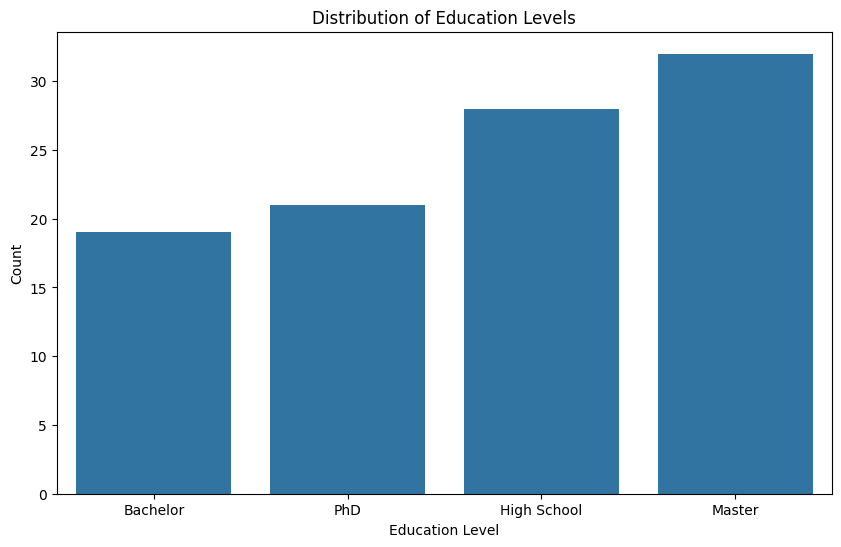

In [4]:
# Data Exploration and Visualization
# Explore the distribution of match scores
plt.figure(figsize=(10, 6))
sns.histplot(matches_df['match_score'], bins=20)
plt.title('Distribution of Match Scores')
plt.xlabel('Match Score')
plt.ylabel('Frequency')
plt.show()

# Explore candidate experience distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='experience', data=candidates_df)
plt.title('Distribution of Candidate Experience')
plt.xlabel('Years of Experience')
plt.ylabel('Count')
plt.show()

# Explore education distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='education', data=candidates_df)
plt.title('Distribution of Education Levels')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.show()

In [6]:
# Feature Engineering - Creating Preprocessing Pipelines

# Create preprocessing pipelines for candidates
def create_candidate_preprocessor(candidates_df):
    # Define different transformers for different types of features

    # Text features - convert skills to TF-IDF vectors
    text_transformer = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=100, stop_words='english'))
    ])

    # Categorical features - one-hot encode education and location
    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Numeric features - scale experience
    numeric_transformer = Pipeline([
        ('scaler', StandardScaler())
    ])

    # Combine transformers using ColumnTransformer
    candidate_preprocessor = ColumnTransformer(
        transformers=[
            ('text', text_transformer, 'skills'),
            ('cat', categorical_transformer, ['education', 'location']),
            ('num', numeric_transformer, ['experience'])
        ],
        remainder='drop'  # Drop other columns not specified
    )

    # Fit the preprocessor on candidates data
    candidate_preprocessor.fit(candidates_df)

    return candidate_preprocessor

# Create preprocessing pipelines for jobs
def create_job_preprocessor(jobs_df):
    # Define different transformers for different types of features

    # Text features - convert required skills and title to TF-IDF vectors
    text_transformer = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=100, stop_words='english'))
    ])

    # Text features for job title
    title_transformer = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=50, stop_words='english'))
    ])

    # Categorical features - one-hot encode education and location
    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Numeric features - scale minimum experience
    numeric_transformer = Pipeline([
        ('scaler', StandardScaler())
    ])

    # Combine transformers using ColumnTransformer
    job_preprocessor = ColumnTransformer(
        transformers=[
            ('skills_text', text_transformer, 'required_skills'),
            ('title_text', title_transformer, 'title'),
            ('cat', categorical_transformer, ['required_education', 'location']),
            ('num', numeric_transformer, ['min_experience'])
        ],
        remainder='drop'  # Drop other columns not specified
    )

    # Fit the preprocessor on jobs data
    job_preprocessor.fit(jobs_df)

    return job_preprocessor

# Create and fit preprocessors
candidate_preprocessor = create_candidate_preprocessor(candidates_df)
job_preprocessor = create_job_preprocessor(jobs_df)

In [7]:
# Transform the data using preprocessors

# Transform candidate data
candidate_features = candidate_preprocessor.transform(candidates_df)
print(f"Candidate features shape: {candidate_features.shape}")

# Transform job data
job_features = job_preprocessor.transform(jobs_df)
print(f"Job features shape: {job_features.shape}")

Candidate features shape: (100, 29)
Job features shape: (50, 42)


In [8]:
# Prepare training data

def prepare_training_data(matches_df, candidates_df, jobs_df, candidate_features, job_features):
    # Create indices for faster lookups
    candidate_indices = {candidate_id: idx for idx, candidate_id in enumerate(candidates_df['id'])}
    job_indices = {job_id: idx for idx, job_id in enumerate(jobs_df['id'])}

    # Create training pairs and scores
    train_pairs = []
    match_scores = []

    for _, row in matches_df.iterrows():
        if row['candidate_id'] in candidate_indices and row['job_id'] in job_indices:
            candidate_idx = candidate_indices[row['candidate_id']]
            job_idx = job_indices[row['job_id']]

            train_pairs.append((candidate_idx, job_idx))
            match_scores.append(row['match_score'])

    # Convert to numpy arrays
    train_pairs = np.array(train_pairs)
    match_scores = np.array(match_scores)

    # Split into training and validation sets
    train_indices, val_indices = train_test_split(
        np.arange(len(train_pairs)),
        test_size=0.2,
        random_state=42
    )

    return train_pairs, match_scores, train_indices, val_indices

# Prepare training data
train_pairs, match_scores, train_indices, val_indices = prepare_training_data(
    matches_df, candidates_df, jobs_df, candidate_features, job_features
)

print(f"Number of training pairs: {len(train_indices)}")
print(f"Number of validation pairs: {len(val_indices)}")

Number of training pairs: 240
Number of validation pairs: 60


In [9]:
# Define the dual-encoder model architecture

def create_embedding_model(input_dim, name=None):
    """Create an encoder model that converts features to embeddings"""
    inputs = tf.keras.layers.Input(shape=(input_dim,))

    # First dense layer with dropout
    x = tf.keras.layers.Dense(256, activation='relu')(inputs)
    x = tf.keras.layers.Dropout(0.2)(x)

    # Second dense layer
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    # Final embedding layer (no activation for embeddings)
    embedding = tf.keras.layers.Dense(128)(x)

    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=embedding, name=name)
    return model

def create_matching_model(candidate_input_dim, job_input_dim):
    """Create the complete matching model with both encoders"""

    # Create encoders
    candidate_encoder = create_embedding_model(candidate_input_dim, "candidate_encoder")
    job_encoder = create_embedding_model(job_input_dim, "job_encoder")

    # Create inputs
    candidate_input = tf.keras.layers.Input(shape=(candidate_input_dim,), name="candidate_input")
    job_input = tf.keras.layers.Input(shape=(job_input_dim,), name="job_input")

    # Get embeddings from encoders
    candidate_embedding = candidate_encoder(candidate_input)
    job_embedding = job_encoder(job_input)

    # Normalize embeddings (for cosine similarity)
    normalized_candidate = tf.keras.layers.Lambda(
        lambda x: tf.math.l2_normalize(x, axis=1))(candidate_embedding)
    normalized_job = tf.keras.layers.Lambda(
        lambda x: tf.math.l2_normalize(x, axis=1))(job_embedding)

    # Calculate similarity (dot product of normalized vectors = cosine similarity)
    similarity = tf.keras.layers.Dot(axes=1)([normalized_candidate, normalized_job])

    # Scale the similarity to produce a match score
    match_score = tf.keras.layers.Dense(1, activation='sigmoid')(similarity)

    # Create the complete model
    model = tf.keras.Model(
        inputs=[candidate_input, job_input],
        outputs=match_score,
        name="matching_model"
    )

    # Also create separate models for inference
    candidate_model = tf.keras.Model(
        inputs=candidate_input,
        outputs=normalized_candidate,
        name="candidate_inference"
    )

    job_model = tf.keras.Model(
        inputs=job_input,
        outputs=normalized_job,
        name="job_inference"
    )

    return model, candidate_model, job_model

# Create the models
matching_model, candidate_model, job_model = create_matching_model(
    candidate_input_dim=candidate_features.shape[1],
    job_input_dim=job_features.shape[1]
)

# Print model summaries
print("Matching Model Summary:")
matching_model.summary()

print("\nCandidate Model Summary:")
candidate_model.summary()

print("\nJob Model Summary:")
job_model.summary()

Matching Model Summary:


Model: "matching_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ candidate_input     │ (None, 29)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ job_input           │ (None, 42)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ candidate_encoder   │ (None, 128)       │     57,088 │ candidate_input[… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ job_encoder         │ (None, 128)       │     60,416 │ job_input[0][0]   │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128)       │          0 │ candidate_encode… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 128)       │          0 │ job_encoder[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1)         │          0 │ lambda[0][0],     │
│                     │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │          2 │ dot[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 117,506 (459.01 KB)

 Trainable params: 117,506 (459.01 KB)

 Non-trainable params: 0 (0.00 B)


Candidate Model Summary:


Model: "candidate_inference"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ candidate_input (InputLayer)    │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ candidate_encoder (Functional)  │ (None, 128)            │        57,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 128)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,088 (223.00 KB)

 Trainable params: 57,088 (223.00 KB)

 Non-trainable params: 0 (0.00 B)


Job Model Summary:


Model: "job_inference"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ job_input (InputLayer)          │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ job_encoder (Functional)        │ (None, 128)            │        60,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 128)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,416 (236.00 KB)

 Trainable params: 60,416 (236.00 KB)

 Non-trainable params: 0 (0.00 B)